In [ ]:
# Load Library

In [4]:
from fastai import *
from fastai.vision import *
import numpy as np
import pandas as pd
import cv2
import zipfile 
from tqdm import tqdm
from fastai.callbacks import CSVLogger
from fastai.callbacks import SaveModelCallback

import torch
from torch import nn
import torch.nn.functional as F

import os

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
height = 137
width = 236
sz = 128
bs = 32 # increase to 128 with better GPU
nfolds = 4 #keep the same split as the initial dataset
fold = 0
SEED = 2019
stats = ([0.0692], [0.2051]) # meand and standard devitiaion
arch = models.densenet169
trfm = get_transforms(do_flip = True, flip_vert = True, max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1. )
train = 'C:\\Users\\bokhy\\Desktop\\kaggle\\bengaliai-cv19\\'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [20]:
df = pd.read_csv('C:\\Users\\bokhy\\Desktop\\kaggle\\bengaliai-cv19\\train.csv')
nunique = list(df.nunique())[1:-1]
print(nunique)
df.head()

[168, 11, 7]


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [8]:
src = (ImageList.from_df(df = df, path = train, folder='train', suffix='.png',cols='image_id', convert_mode='L')
       .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
       .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic']))

data = (src.transform(tfms = get_transforms(), size = sz, padding_mode = 'zeros')
        .databunch(bs=bs).normalize(stats))

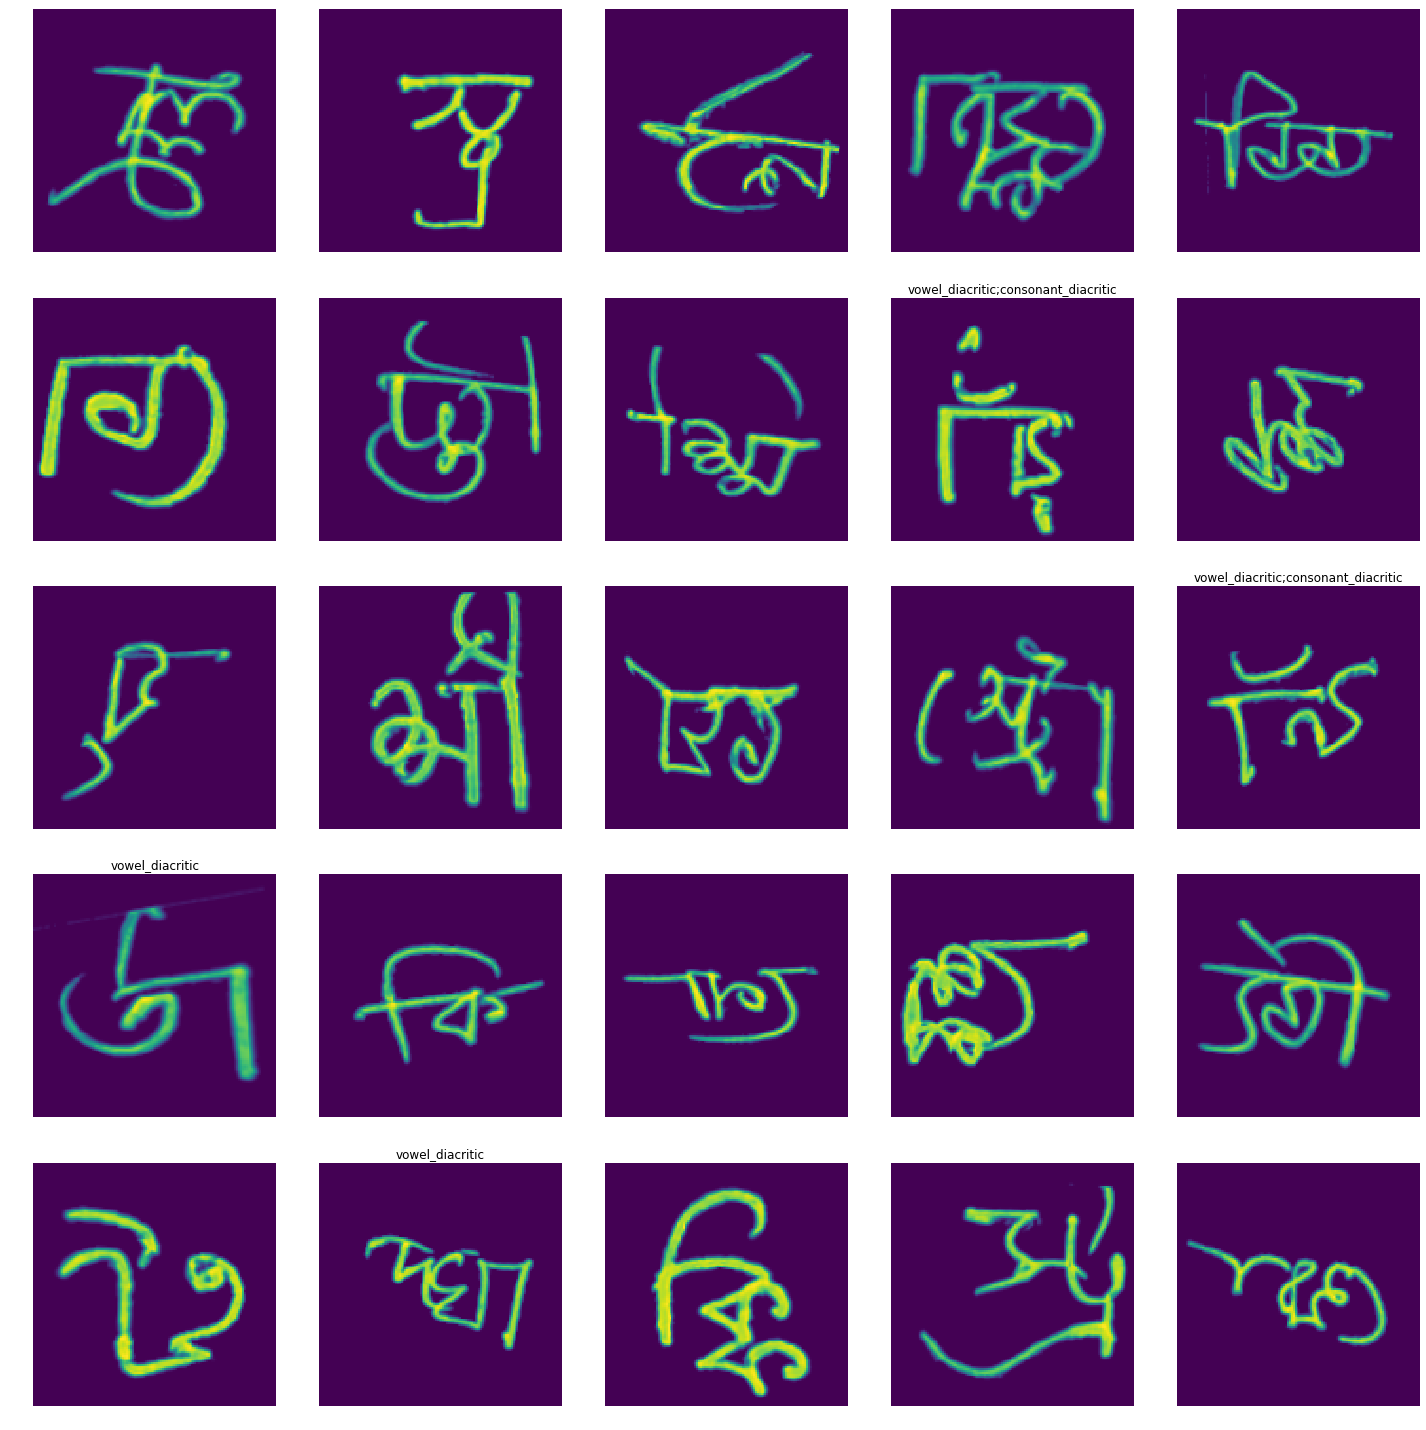

In [9]:
data.show_batch()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [21]:
class Head(nn.Module):
    def __init__(self, nc, n, ps=0.5):
        super().__init__()
        layers = [AdaptiveConcatPool2d(), Mish(), Flatten()] + \
            bn_drop_lin(nc*2, 512, True, ps, Mish()) + \
            bn_drop_lin(512, n, True, ps)
        self.fc = nn.Sequential(*layers)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)

#change the first conv to accept 1 chanel input
class Dnet_1ch(nn.Module):
    def __init__(self, arch=arch, n=nunique, pre=True, ps=0.5, dtype=torch.float64):
        super().__init__()
        m = arch(True) if pre else arch()
        
        conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        w = (m.features.conv0.weight.sum(1)).unsqueeze(1)
        conv.weight = nn.Parameter(w)
        
        self.layer0 = nn.Sequential(conv, m.features.norm0, nn.ReLU(inplace=True))
        self.layer1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
            m.features.denseblock1)
        self.layer2 = nn.Sequential(m.features.transition1,m.features.denseblock2)
        self.layer3 = nn.Sequential(m.features.transition2,m.features.denseblock3)
        self.layer4 = nn.Sequential(m.features.transition3,m.features.denseblock4,
                                    m.features.norm5)
        
        nc = self.layer4[-1].weight.shape[0]
        self.head1 = Head(nc,n[0])
        self.head2 = Head(nc,n[1])
        self.head3 = Head(nc,n[2])
        #to_Mish(self.layer0), to_Mish(self.layer1), to_Mish(self.layer2)
        #to_Mish(self.layer3), to_Mish(self.layer4)
        
    def forward(self, x):    
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x1 = self.head1(x)
        x2 = self.head2(x)
        x3 = self.head3(x)
        
        return x1,x2,x3

In [9]:
# Loss 
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target,reduction='mean'):
        x1,x2,x3 = input
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        return 0.7*F.cross_entropy(x1,y[:,0],reduction=reduction) + 0.1*F.cross_entropy(x2,y[:,1],reduction=reduction) + \
          0.2*F.cross_entropy(x3,y[:,2],reduction=reduction)

In [10]:
class Metric_idx(Callback):
    def __init__(self, idx, average='macro'):
        super().__init__()
        self.idx = idx
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[:,self.idx]
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx,0)
Metric_vowel = partial(Metric_idx,1)
Metric_consonant = partial(Metric_idx,2)

class Metric_tot(Callback):
    def __init__(self):
        super().__init__()
        self.grapheme = Metric_idx(0)
        self.vowel = Metric_idx(1)
        self.consonant = Metric_idx(2)
        
    def on_epoch_begin(self, **kwargs):
        self.grapheme.on_epoch_begin(**kwargs)
        self.vowel.on_epoch_begin(**kwargs)
        self.consonant.on_epoch_begin(**kwargs)
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.grapheme.on_batch_end(last_output, last_target, **kwargs)
        self.vowel.on_batch_end(last_output, last_target, **kwargs)
        self.consonant.on_batch_end(last_output, last_target, **kwargs)
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 0.5*self.grapheme._recall() +
                0.25*self.vowel._recall() + 0.25*self.consonant._recall())

In [11]:
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto'):
        super().__init__(learn)
        self.monitor,self.mode = monitor,mode
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__class__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor or 'error' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]

    def on_train_begin(self, **kwargs:Any)->None:
        "Initializes the best value."
        self.best = float('inf') if self.operator == np.less else -float('inf')

    def get_monitor_value(self):
        "Pick the monitored value."
        if self.monitor=='trn_loss' and len(self.learn.recorder.losses) == 0: return None
        elif len(self.learn.recorder.val_losses) == 0: return None
        values = {'train_loss':self.learn.recorder.losses[-1].cpu().numpy(),
                  'valid_loss':self.learn.recorder.val_losses[-1]}
        if values['valid_loss'] is None: return
        if self.learn.recorder.metrics:
            for m, n in zip(self.learn.recorder.metrics[-1],self.learn.recorder.names[3:-1]):
                values[n] = m
        if values.get(self.monitor) is None:
            warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')
        return values.get(self.monitor)

In [12]:
#fix the issue in fast.ai of saving gradients along with weights
#so only weights are written, and files are ~4 times smaller

class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto',
                 every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
                 
    def jump_to_epoch(self, epoch:int)->None:
        try: 
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": 
            #self.learn.save(f'{self.name}_{epoch}')
            torch.save(learn.model.state_dict(),f'{self.name}_{epoch}.pth')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                #print(f'Better model found at epoch {epoch} \
                #  with {self.monitor} value: {current}.')
                self.best = current
                #self.learn.save(f'{self.name}')
                torch.save(learn.model.state_dict(),f'{self.name}.pth')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and os.path.isfile(f'{self.name}.pth'):
            #self.learn.load(f'{self.name}', purge=False)
            self.model.load_state_dict(torch.load(f'{self.name}.pth'))

In [13]:
class MixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.shape) == 2 and target.shape[1] == 7:
            loss1, loss2 = self.crit(output,target[:,0:3].long()), self.crit(output,target[:,3:6].long())
            d = loss1 * target[:,-1] + loss2 * (1-target[:,-1])
        else:  d = self.crit(output, target)
        if self.reduction == 'mean':    return d.mean()
        elif self.reduction == 'sum':   return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            new_target = torch.cat([last_target.float(), y1.float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()

In [14]:
import math
import torch
import itertools as it
from torch.optim import Optimizer
from collections import defaultdict

class Lookahead(Optimizer):
    '''
    PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    '''
    def __init__(self, optimizer,alpha=0.5, k=6,pullback_momentum="none"):
        '''
        :param optimizer:inner optimizer
        :param k (int): number of lookahead steps
        :param alpha(float): linear interpolation factor. 1.0 recovers the inner optimizer.
        :param pullback_momentum (str): change to inner optimizer momentum on interpolation update
        '''
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        self.optimizer = optimizer
        self.param_groups = self.optimizer.param_groups
        self.alpha = alpha
        self.k = k
        self.step_counter = 0
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum
        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'alpha': self.alpha,
            'step_counter': self.step_counter,
            'k':self.k,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self.step_counter += 1

        if self.step_counter >= self.k:
            self.step_counter = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.alpha).add_(1.0 - self.alpha, param_state['cached_params'])  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.alpha).add_(
                            1.0 - self.alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

In [15]:
import torch, math
from torch.optim.optimizer import Optimizer

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [16]:
import torch, math
from torch.optim.optimizer import Optimizer
import itertools as it

# RAdam + LARS + LookAHead

# Lookahead implementation from https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
# RAdam + LARS implementation from https://gist.github.com/redknightlois/c4023d393eb8f92bb44b2ab582d7ec20

def Over9000(params, alpha=0.5, k=6, *args, **kwargs):
     ralamb = Ralamb(params, *args, **kwargs)
     return Lookahead(ralamb, alpha, k)

RangerLars = Over9000

In [21]:
model = Dnet_1ch()
learn = Learner(data, model, loss_func=Loss_combine(), opt_func=Over9000,
        metrics=[Metric_grapheme(),Metric_vowel(),Metric_consonant(),Metric_tot()])

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to C:\Users\bokhy/.cache\torch\checkpoints\densenet169-b2777c0a.pth
100%|█████████████████████████████████████████████████████████████████████████████| 54.7M/54.7M [00:06<00:00, 9.20MB/s]


In [22]:
logger = CSVLogger(learn,f'log{fold}')

In [33]:
# did not run yet
learn.clip_grad = 1.0
learn.split([model.head1])
learn.unfreeze()

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,accuracy,time


c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  del sys.path[0]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


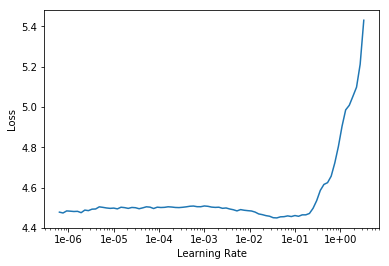

In [26]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(5, 1e-2, wd=1e-3, pct_start=0.3,
                    callbacks = [logger, SaveModelCallback(learn,monitor='metric_tot',mode='max'),MixUpCallback(learn)])

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.712997,0.881516,0.650182,0.826146,0.830341,0.739213,2:15:43
1,1.397780,0.361174,0.835802,0.910069,0.930542,0.878054,2:01:48
2,1.252557,0.243107,0.900373,0.952039,0.957840,0.927656,2:03:25
3,1.102178,0.174186,0.929359,0.971444,0.962558,0.948180,1:59:23
4,1.090087,0.152346,0.936279,0.972875,0.969016,0.953612,1:57:34


c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  del sys.path[0]


In [27]:
learn.save('Grapheme',return_path=True)

WindowsPath('C:/Users/bokhy/Desktop/kaggle/bengaliai-cv19/models/Grapheme.pth')

In [28]:
learn.export('Grapheme.pkl')

In [28]:
learn = load_learner(path = train, file = 'Grapheme.pkl')

In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
from tqdm import tqdm_notebook as tqdm
import fastai
from fastai.vision import *
import os
import warnings
warnings.filterwarnings("ignore")

In [30]:
MODEL = 'C:\\Users\\bokhy\\Desktop\\kaggle\\bengaliai-cv19\\models\\Grapheme.pth'
nworkers = 0

TEST = ['C:\\Users\\bokhy\\Desktop\\kaggle\\bengaliai-cv19\\test_image_data_0.parquet',
        'C:\\Users\\bokhy\\Desktop\\kaggle\\bengaliai-cv19\\test_image_data_1.parquet',
        'C:\\Users\\bokhy\\Desktop\\kaggle\\bengaliai-cv19\\test_image_data_2.parquet',
        'C:\\Users\\bokhy\\Desktop\\kaggle\\bengaliai-cv19\\test_image_data_3.parquet']

LABELS = 'C:\\Users\\bokhy\\Desktop\\kaggle\\bengaliai-cv19\\train.csv'

df = pd.read_csv(LABELS)
nunique = list(df.nunique())[1:-1]
print(nunique)
df.head(5)

[168, 11, 7]


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


# Model 

In [32]:
model = Dnet_1ch(pre=False).cuda()
model.load_state_dict(torch.load(MODEL));
model.eval();

RuntimeError: Error(s) in loading state_dict for Dnet_1ch:
	Missing key(s) in state_dict: "layer0.0.weight", "layer0.1.weight", "layer0.1.bias", "layer0.1.running_mean", "layer0.1.running_var", "layer1.1.denselayer1.norm1.weight", "layer1.1.denselayer1.norm1.bias", "layer1.1.denselayer1.norm1.running_mean", "layer1.1.denselayer1.norm1.running_var", "layer1.1.denselayer1.conv1.weight", "layer1.1.denselayer1.norm2.weight", "layer1.1.denselayer1.norm2.bias", "layer1.1.denselayer1.norm2.running_mean", "layer1.1.denselayer1.norm2.running_var", "layer1.1.denselayer1.conv2.weight", "layer1.1.denselayer2.norm1.weight", "layer1.1.denselayer2.norm1.bias", "layer1.1.denselayer2.norm1.running_mean", "layer1.1.denselayer2.norm1.running_var", "layer1.1.denselayer2.conv1.weight", "layer1.1.denselayer2.norm2.weight", "layer1.1.denselayer2.norm2.bias", "layer1.1.denselayer2.norm2.running_mean", "layer1.1.denselayer2.norm2.running_var", "layer1.1.denselayer2.conv2.weight", "layer1.1.denselayer3.norm1.weight", "layer1.1.denselayer3.norm1.bias", "layer1.1.denselayer3.norm1.running_mean", "layer1.1.denselayer3.norm1.running_var", "layer1.1.denselayer3.conv1.weight", "layer1.1.denselayer3.norm2.weight", "layer1.1.denselayer3.norm2.bias", "layer1.1.denselayer3.norm2.running_mean", "layer1.1.denselayer3.norm2.running_var", "layer1.1.denselayer3.conv2.weight", "layer1.1.denselayer4.norm1.weight", "layer1.1.denselayer4.norm1.bias", "layer1.1.denselayer4.norm1.running_mean", "layer1.1.denselayer4.norm1.running_var", "layer1.1.denselayer4.conv1.weight", "layer1.1.denselayer4.norm2.weight", "layer1.1.denselayer4.norm2.bias", "layer1.1.denselayer4.norm2.running_mean", "layer1.1.denselayer4.norm2.running_var", "layer1.1.denselayer4.conv2.weight", "layer1.1.denselayer5.norm1.weight", "layer1.1.denselayer5.norm1.bias", "layer1.1.denselayer5.norm1.running_mean", "layer1.1.denselayer5.norm1.running_var", "layer1.1.denselayer5.conv1.weight", "layer1.1.denselayer5.norm2.weight", "layer1.1.denselayer5.norm2.bias", "layer1.1.denselayer5.norm2.running_mean", "layer1.1.denselayer5.norm2.running_var", "layer1.1.denselayer5.conv2.weight", "layer1.1.denselayer6.norm1.weight", "layer1.1.denselayer6.norm1.bias", "layer1.1.denselayer6.norm1.running_mean", "layer1.1.denselayer6.norm1.running_var", "layer1.1.denselayer6.conv1.weight", "layer1.1.denselayer6.norm2.weight", "layer1.1.denselayer6.norm2.bias", "layer1.1.denselayer6.norm2.running_mean", "layer1.1.denselayer6.norm2.running_var", "layer1.1.denselayer6.conv2.weight", "layer2.0.norm.weight", "layer2.0.norm.bias", "layer2.0.norm.running_mean", "layer2.0.norm.running_var", "layer2.0.conv.weight", "layer2.1.denselayer1.norm1.weight", "layer2.1.denselayer1.norm1.bias", "layer2.1.denselayer1.norm1.running_mean", "layer2.1.denselayer1.norm1.running_var", "layer2.1.denselayer1.conv1.weight", "layer2.1.denselayer1.norm2.weight", "layer2.1.denselayer1.norm2.bias", "layer2.1.denselayer1.norm2.running_mean", "layer2.1.denselayer1.norm2.running_var", "layer2.1.denselayer1.conv2.weight", "layer2.1.denselayer2.norm1.weight", "layer2.1.denselayer2.norm1.bias", "layer2.1.denselayer2.norm1.running_mean", "layer2.1.denselayer2.norm1.running_var", "layer2.1.denselayer2.conv1.weight", "layer2.1.denselayer2.norm2.weight", "layer2.1.denselayer2.norm2.bias", "layer2.1.denselayer2.norm2.running_mean", "layer2.1.denselayer2.norm2.running_var", "layer2.1.denselayer2.conv2.weight", "layer2.1.denselayer3.norm1.weight", "layer2.1.denselayer3.norm1.bias", "layer2.1.denselayer3.norm1.running_mean", "layer2.1.denselayer3.norm1.running_var", "layer2.1.denselayer3.conv1.weight", "layer2.1.denselayer3.norm2.weight", "layer2.1.denselayer3.norm2.bias", "layer2.1.denselayer3.norm2.running_mean", "layer2.1.denselayer3.norm2.running_var", "layer2.1.denselayer3.conv2.weight", "layer2.1.denselayer4.norm1.weight", "layer2.1.denselayer4.norm1.bias", "layer2.1.denselayer4.norm1.running_mean", "layer2.1.denselayer4.norm1.running_var", "layer2.1.denselayer4.conv1.weight", "layer2.1.denselayer4.norm2.weight", "layer2.1.denselayer4.norm2.bias", "layer2.1.denselayer4.norm2.running_mean", "layer2.1.denselayer4.norm2.running_var", "layer2.1.denselayer4.conv2.weight", "layer2.1.denselayer5.norm1.weight", "layer2.1.denselayer5.norm1.bias", "layer2.1.denselayer5.norm1.running_mean", "layer2.1.denselayer5.norm1.running_var", "layer2.1.denselayer5.conv1.weight", "layer2.1.denselayer5.norm2.weight", "layer2.1.denselayer5.norm2.bias", "layer2.1.denselayer5.norm2.running_mean", "layer2.1.denselayer5.norm2.running_var", "layer2.1.denselayer5.conv2.weight", "layer2.1.denselayer6.norm1.weight", "layer2.1.denselayer6.norm1.bias", "layer2.1.denselayer6.norm1.running_mean", "layer2.1.denselayer6.norm1.running_var", "layer2.1.denselayer6.conv1.weight", "layer2.1.denselayer6.norm2.weight", "layer2.1.denselayer6.norm2.bias", "layer2.1.denselayer6.norm2.running_mean", "layer2.1.denselayer6.norm2.running_var", "layer2.1.denselayer6.conv2.weight", "layer2.1.denselayer7.norm1.weight", "layer2.1.denselayer7.norm1.bias", "layer2.1.denselayer7.norm1.running_mean", "layer2.1.denselayer7.norm1.running_var", "layer2.1.denselayer7.conv1.weight", "layer2.1.denselayer7.norm2.weight", "layer2.1.denselayer7.norm2.bias", "layer2.1.denselayer7.norm2.running_mean", "layer2.1.denselayer7.norm2.running_var", "layer2.1.denselayer7.conv2.weight", "layer2.1.denselayer8.norm1.weight", "layer2.1.denselayer8.norm1.bias", "layer2.1.denselayer8.norm1.running_mean", "layer2.1.denselayer8.norm1.running_var", "layer2.1.denselayer8.conv1.weight", "layer2.1.denselayer8.norm2.weight", "layer2.1.denselayer8.norm2.bias", "layer2.1.denselayer8.norm2.running_mean", "layer2.1.denselayer8.norm2.running_var", "layer2.1.denselayer8.conv2.weight", "layer2.1.denselayer9.norm1.weight", "layer2.1.denselayer9.norm1.bias", "layer2.1.denselayer9.norm1.running_mean", "layer2.1.denselayer9.norm1.running_var", "layer2.1.denselayer9.conv1.weight", "layer2.1.denselayer9.norm2.weight", "layer2.1.denselayer9.norm2.bias", "layer2.1.denselayer9.norm2.running_mean", "layer2.1.denselayer9.norm2.running_var", "layer2.1.denselayer9.conv2.weight", "layer2.1.denselayer10.norm1.weight", "layer2.1.denselayer10.norm1.bias", "layer2.1.denselayer10.norm1.running_mean", "layer2.1.denselayer10.norm1.running_var", "layer2.1.denselayer10.conv1.weight", "layer2.1.denselayer10.norm2.weight", "layer2.1.denselayer10.norm2.bias", "layer2.1.denselayer10.norm2.running_mean", "layer2.1.denselayer10.norm2.running_var", "layer2.1.denselayer10.conv2.weight", "layer2.1.denselayer11.norm1.weight", "layer2.1.denselayer11.norm1.bias", "layer2.1.denselayer11.norm1.running_mean", "layer2.1.denselayer11.norm1.running_var", "layer2.1.denselayer11.conv1.weight", "layer2.1.denselayer11.norm2.weight", "layer2.1.denselayer11.norm2.bias", "layer2.1.denselayer11.norm2.running_mean", "layer2.1.denselayer11.norm2.running_var", "layer2.1.denselayer11.conv2.weight", "layer2.1.denselayer12.norm1.weight", "layer2.1.denselayer12.norm1.bias", "layer2.1.denselayer12.norm1.running_mean", "layer2.1.denselayer12.norm1.running_var", "layer2.1.denselayer12.conv1.weight", "layer2.1.denselayer12.norm2.weight", "layer2.1.denselayer12.norm2.bias", "layer2.1.denselayer12.norm2.running_mean", "layer2.1.denselayer12.norm2.running_var", "layer2.1.denselayer12.conv2.weight", "layer3.0.norm.weight", "layer3.0.norm.bias", "layer3.0.norm.running_mean", "layer3.0.norm.running_var", "layer3.0.conv.weight", "layer3.1.denselayer1.norm1.weight", "layer3.1.denselayer1.norm1.bias", "layer3.1.denselayer1.norm1.running_mean", "layer3.1.denselayer1.norm1.running_var", "layer3.1.denselayer1.conv1.weight", "layer3.1.denselayer1.norm2.weight", "layer3.1.denselayer1.norm2.bias", "layer3.1.denselayer1.norm2.running_mean", "layer3.1.denselayer1.norm2.running_var", "layer3.1.denselayer1.conv2.weight", "layer3.1.denselayer2.norm1.weight", "layer3.1.denselayer2.norm1.bias", "layer3.1.denselayer2.norm1.running_mean", "layer3.1.denselayer2.norm1.running_var", "layer3.1.denselayer2.conv1.weight", "layer3.1.denselayer2.norm2.weight", "layer3.1.denselayer2.norm2.bias", "layer3.1.denselayer2.norm2.running_mean", "layer3.1.denselayer2.norm2.running_var", "layer3.1.denselayer2.conv2.weight", "layer3.1.denselayer3.norm1.weight", "layer3.1.denselayer3.norm1.bias", "layer3.1.denselayer3.norm1.running_mean", "layer3.1.denselayer3.norm1.running_var", "layer3.1.denselayer3.conv1.weight", "layer3.1.denselayer3.norm2.weight", "layer3.1.denselayer3.norm2.bias", "layer3.1.denselayer3.norm2.running_mean", "layer3.1.denselayer3.norm2.running_var", "layer3.1.denselayer3.conv2.weight", "layer3.1.denselayer4.norm1.weight", "layer3.1.denselayer4.norm1.bias", "layer3.1.denselayer4.norm1.running_mean", "layer3.1.denselayer4.norm1.running_var", "layer3.1.denselayer4.conv1.weight", "layer3.1.denselayer4.norm2.weight", "layer3.1.denselayer4.norm2.bias", "layer3.1.denselayer4.norm2.running_mean", "layer3.1.denselayer4.norm2.running_var", "layer3.1.denselayer4.conv2.weight", "layer3.1.denselayer5.norm1.weight", "layer3.1.denselayer5.norm1.bias", "layer3.1.denselayer5.norm1.running_mean", "layer3.1.denselayer5.norm1.running_var", "layer3.1.denselayer5.conv1.weight", "layer3.1.denselayer5.norm2.weight", "layer3.1.denselayer5.norm2.bias", "layer3.1.denselayer5.norm2.running_mean", "layer3.1.denselayer5.norm2.running_var", "layer3.1.denselayer5.conv2.weight", "layer3.1.denselayer6.norm1.weight", "layer3.1.denselayer6.norm1.bias", "layer3.1.denselayer6.norm1.running_mean", "layer3.1.denselayer6.norm1.running_var", "layer3.1.denselayer6.conv1.weight", "layer3.1.denselayer6.norm2.weight", "layer3.1.denselayer6.norm2.bias", "layer3.1.denselayer6.norm2.running_mean", "layer3.1.denselayer6.norm2.running_var", "layer3.1.denselayer6.conv2.weight", "layer3.1.denselayer7.norm1.weight", "layer3.1.denselayer7.norm1.bias", "layer3.1.denselayer7.norm1.running_mean", "layer3.1.denselayer7.norm1.running_var", "layer3.1.denselayer7.conv1.weight", "layer3.1.denselayer7.norm2.weight", "layer3.1.denselayer7.norm2.bias", "layer3.1.denselayer7.norm2.running_mean", "layer3.1.denselayer7.norm2.running_var", "layer3.1.denselayer7.conv2.weight", "layer3.1.denselayer8.norm1.weight", "layer3.1.denselayer8.norm1.bias", "layer3.1.denselayer8.norm1.running_mean", "layer3.1.denselayer8.norm1.running_var", "layer3.1.denselayer8.conv1.weight", "layer3.1.denselayer8.norm2.weight", "layer3.1.denselayer8.norm2.bias", "layer3.1.denselayer8.norm2.running_mean", "layer3.1.denselayer8.norm2.running_var", "layer3.1.denselayer8.conv2.weight", "layer3.1.denselayer9.norm1.weight", "layer3.1.denselayer9.norm1.bias", "layer3.1.denselayer9.norm1.running_mean", "layer3.1.denselayer9.norm1.running_var", "layer3.1.denselayer9.conv1.weight", "layer3.1.denselayer9.norm2.weight", "layer3.1.denselayer9.norm2.bias", "layer3.1.denselayer9.norm2.running_mean", "layer3.1.denselayer9.norm2.running_var", "layer3.1.denselayer9.conv2.weight", "layer3.1.denselayer10.norm1.weight", "layer3.1.denselayer10.norm1.bias", "layer3.1.denselayer10.norm1.running_mean", "layer3.1.denselayer10.norm1.running_var", "layer3.1.denselayer10.conv1.weight", "layer3.1.denselayer10.norm2.weight", "layer3.1.denselayer10.norm2.bias", "layer3.1.denselayer10.norm2.running_mean", "layer3.1.denselayer10.norm2.running_var", "layer3.1.denselayer10.conv2.weight", "layer3.1.denselayer11.norm1.weight", "layer3.1.denselayer11.norm1.bias", "layer3.1.denselayer11.norm1.running_mean", "layer3.1.denselayer11.norm1.running_var", "layer3.1.denselayer11.conv1.weight", "layer3.1.denselayer11.norm2.weight", "layer3.1.denselayer11.norm2.bias", "layer3.1.denselayer11.norm2.running_mean", "layer3.1.denselayer11.norm2.running_var", "layer3.1.denselayer11.conv2.weight", "layer3.1.denselayer12.norm1.weight", "layer3.1.denselayer12.norm1.bias", "layer3.1.denselayer12.norm1.running_mean", "layer3.1.denselayer12.norm1.running_var", "layer3.1.denselayer12.conv1.weight", "layer3.1.denselayer12.norm2.weight", "layer3.1.denselayer12.norm2.bias", "layer3.1.denselayer12.norm2.running_mean", "layer3.1.denselayer12.norm2.running_var", "layer3.1.denselayer12.conv2.weight", "layer3.1.denselayer13.norm1.weight", "layer3.1.denselayer13.norm1.bias", "layer3.1.denselayer13.norm1.running_mean", "layer3.1.denselayer13.norm1.running_var", "layer3.1.denselayer13.conv1.weight", "layer3.1.denselayer13.norm2.weight", "layer3.1.denselayer13.norm2.bias", "layer3.1.denselayer13.norm2.running_mean", "layer3.1.denselayer13.norm2.running_var", "layer3.1.denselayer13.conv2.weight", "layer3.1.denselayer14.norm1.weight", "layer3.1.denselayer14.norm1.bias", "layer3.1.denselayer14.norm1.running_mean", "layer3.1.denselayer14.norm1.running_var", "layer3.1.denselayer14.conv1.weight", "layer3.1.denselayer14.norm2.weight", "layer3.1.denselayer14.norm2.bias", "layer3.1.denselayer14.norm2.running_mean", "layer3.1.denselayer14.norm2.running_var", "layer3.1.denselayer14.conv2.weight", "layer3.1.denselayer15.norm1.weight", "layer3.1.denselayer15.norm1.bias", "layer3.1.denselayer15.norm1.running_mean", "layer3.1.denselayer15.norm1.running_var", "layer3.1.denselayer15.conv1.weight", "layer3.1.denselayer15.norm2.weight", "layer3.1.denselayer15.norm2.bias", "layer3.1.denselayer15.norm2.running_mean", "layer3.1.denselayer15.norm2.running_var", "layer3.1.denselayer15.conv2.weight", "layer3.1.denselayer16.norm1.weight", "layer3.1.denselayer16.norm1.bias", "layer3.1.denselayer16.norm1.running_mean", "layer3.1.denselayer16.norm1.running_var", "layer3.1.denselayer16.conv1.weight", "layer3.1.denselayer16.norm2.weight", "layer3.1.denselayer16.norm2.bias", "layer3.1.denselayer16.norm2.running_mean", "layer3.1.denselayer16.norm2.running_var", "layer3.1.denselayer16.conv2.weight", "layer3.1.denselayer17.norm1.weight", "layer3.1.denselayer17.norm1.bias", "layer3.1.denselayer17.norm1.running_mean", "layer3.1.denselayer17.norm1.running_var", "layer3.1.denselayer17.conv1.weight", "layer3.1.denselayer17.norm2.weight", "layer3.1.denselayer17.norm2.bias", "layer3.1.denselayer17.norm2.running_mean", "layer3.1.denselayer17.norm2.running_var", "layer3.1.denselayer17.conv2.weight", "layer3.1.denselayer18.norm1.weight", "layer3.1.denselayer18.norm1.bias", "layer3.1.denselayer18.norm1.running_mean", "layer3.1.denselayer18.norm1.running_var", "layer3.1.denselayer18.conv1.weight", "layer3.1.denselayer18.norm2.weight", "layer3.1.denselayer18.norm2.bias", "layer3.1.denselayer18.norm2.running_mean", "layer3.1.denselayer18.norm2.running_var", "layer3.1.denselayer18.conv2.weight", "layer3.1.denselayer19.norm1.weight", "layer3.1.denselayer19.norm1.bias", "layer3.1.denselayer19.norm1.running_mean", "layer3.1.denselayer19.norm1.running_var", "layer3.1.denselayer19.conv1.weight", "layer3.1.denselayer19.norm2.weight", "layer3.1.denselayer19.norm2.bias", "layer3.1.denselayer19.norm2.running_mean", "layer3.1.denselayer19.norm2.running_var", "layer3.1.denselayer19.conv2.weight", "layer3.1.denselayer20.norm1.weight", "layer3.1.denselayer20.norm1.bias", "layer3.1.denselayer20.norm1.running_mean", "layer3.1.denselayer20.norm1.running_var", "layer3.1.denselayer20.conv1.weight", "layer3.1.denselayer20.norm2.weight", "layer3.1.denselayer20.norm2.bias", "layer3.1.denselayer20.norm2.running_mean", "layer3.1.denselayer20.norm2.running_var", "layer3.1.denselayer20.conv2.weight", "layer3.1.denselayer21.norm1.weight", "layer3.1.denselayer21.norm1.bias", "layer3.1.denselayer21.norm1.running_mean", "layer3.1.denselayer21.norm1.running_var", "layer3.1.denselayer21.conv1.weight", "layer3.1.denselayer21.norm2.weight", "layer3.1.denselayer21.norm2.bias", "layer3.1.denselayer21.norm2.running_mean", "layer3.1.denselayer21.norm2.running_var", "layer3.1.denselayer21.conv2.weight", "layer3.1.denselayer22.norm1.weight", "layer3.1.denselayer22.norm1.bias", "layer3.1.denselayer22.norm1.running_mean", "layer3.1.denselayer22.norm1.running_var", "layer3.1.denselayer22.conv1.weight", "layer3.1.denselayer22.norm2.weight", "layer3.1.denselayer22.norm2.bias", "layer3.1.denselayer22.norm2.running_mean", "layer3.1.denselayer22.norm2.running_var", "layer3.1.denselayer22.conv2.weight", "layer3.1.denselayer23.norm1.weight", "layer3.1.denselayer23.norm1.bias", "layer3.1.denselayer23.norm1.running_mean", "layer3.1.denselayer23.norm1.running_var", "layer3.1.denselayer23.conv1.weight", "layer3.1.denselayer23.norm2.weight", "layer3.1.denselayer23.norm2.bias", "layer3.1.denselayer23.norm2.running_mean", "layer3.1.denselayer23.norm2.running_var", "layer3.1.denselayer23.conv2.weight", "layer3.1.denselayer24.norm1.weight", "layer3.1.denselayer24.norm1.bias", "layer3.1.denselayer24.norm1.running_mean", "layer3.1.denselayer24.norm1.running_var", "layer3.1.denselayer24.conv1.weight", "layer3.1.denselayer24.norm2.weight", "layer3.1.denselayer24.norm2.bias", "layer3.1.denselayer24.norm2.running_mean", "layer3.1.denselayer24.norm2.running_var", "layer3.1.denselayer24.conv2.weight", "layer3.1.denselayer25.norm1.weight", "layer3.1.denselayer25.norm1.bias", "layer3.1.denselayer25.norm1.running_mean", "layer3.1.denselayer25.norm1.running_var", "layer3.1.denselayer25.conv1.weight", "layer3.1.denselayer25.norm2.weight", "layer3.1.denselayer25.norm2.bias", "layer3.1.denselayer25.norm2.running_mean", "layer3.1.denselayer25.norm2.running_var", "layer3.1.denselayer25.conv2.weight", "layer3.1.denselayer26.norm1.weight", "layer3.1.denselayer26.norm1.bias", "layer3.1.denselayer26.norm1.running_mean", "layer3.1.denselayer26.norm1.running_var", "layer3.1.denselayer26.conv1.weight", "layer3.1.denselayer26.norm2.weight", "layer3.1.denselayer26.norm2.bias", "layer3.1.denselayer26.norm2.running_mean", "layer3.1.denselayer26.norm2.running_var", "layer3.1.denselayer26.conv2.weight", "layer3.1.denselayer27.norm1.weight", "layer3.1.denselayer27.norm1.bias", "layer3.1.denselayer27.norm1.running_mean", "layer3.1.denselayer27.norm1.running_var", "layer3.1.denselayer27.conv1.weight", "layer3.1.denselayer27.norm2.weight", "layer3.1.denselayer27.norm2.bias", "layer3.1.denselayer27.norm2.running_mean", "layer3.1.denselayer27.norm2.running_var", "layer3.1.denselayer27.conv2.weight", "layer3.1.denselayer28.norm1.weight", "layer3.1.denselayer28.norm1.bias", "layer3.1.denselayer28.norm1.running_mean", "layer3.1.denselayer28.norm1.running_var", "layer3.1.denselayer28.conv1.weight", "layer3.1.denselayer28.norm2.weight", "layer3.1.denselayer28.norm2.bias", "layer3.1.denselayer28.norm2.running_mean", "layer3.1.denselayer28.norm2.running_var", "layer3.1.denselayer28.conv2.weight", "layer3.1.denselayer29.norm1.weight", "layer3.1.denselayer29.norm1.bias", "layer3.1.denselayer29.norm1.running_mean", "layer3.1.denselayer29.norm1.running_var", "layer3.1.denselayer29.conv1.weight", "layer3.1.denselayer29.norm2.weight", "layer3.1.denselayer29.norm2.bias", "layer3.1.denselayer29.norm2.running_mean", "layer3.1.denselayer29.norm2.running_var", "layer3.1.denselayer29.conv2.weight", "layer3.1.denselayer30.norm1.weight", "layer3.1.denselayer30.norm1.bias", "layer3.1.denselayer30.norm1.running_mean", "layer3.1.denselayer30.norm1.running_var", "layer3.1.denselayer30.conv1.weight", "layer3.1.denselayer30.norm2.weight", "layer3.1.denselayer30.norm2.bias", "layer3.1.denselayer30.norm2.running_mean", "layer3.1.denselayer30.norm2.running_var", "layer3.1.denselayer30.conv2.weight", "layer3.1.denselayer31.norm1.weight", "layer3.1.denselayer31.norm1.bias", "layer3.1.denselayer31.norm1.running_mean", "layer3.1.denselayer31.norm1.running_var", "layer3.1.denselayer31.conv1.weight", "layer3.1.denselayer31.norm2.weight", "layer3.1.denselayer31.norm2.bias", "layer3.1.denselayer31.norm2.running_mean", "layer3.1.denselayer31.norm2.running_var", "layer3.1.denselayer31.conv2.weight", "layer3.1.denselayer32.norm1.weight", "layer3.1.denselayer32.norm1.bias", "layer3.1.denselayer32.norm1.running_mean", "layer3.1.denselayer32.norm1.running_var", "layer3.1.denselayer32.conv1.weight", "layer3.1.denselayer32.norm2.weight", "layer3.1.denselayer32.norm2.bias", "layer3.1.denselayer32.norm2.running_mean", "layer3.1.denselayer32.norm2.running_var", "layer3.1.denselayer32.conv2.weight", "layer4.0.norm.weight", "layer4.0.norm.bias", "layer4.0.norm.running_mean", "layer4.0.norm.running_var", "layer4.0.conv.weight", "layer4.1.denselayer1.norm1.weight", "layer4.1.denselayer1.norm1.bias", "layer4.1.denselayer1.norm1.running_mean", "layer4.1.denselayer1.norm1.running_var", "layer4.1.denselayer1.conv1.weight", "layer4.1.denselayer1.norm2.weight", "layer4.1.denselayer1.norm2.bias", "layer4.1.denselayer1.norm2.running_mean", "layer4.1.denselayer1.norm2.running_var", "layer4.1.denselayer1.conv2.weight", "layer4.1.denselayer2.norm1.weight", "layer4.1.denselayer2.norm1.bias", "layer4.1.denselayer2.norm1.running_mean", "layer4.1.denselayer2.norm1.running_var", "layer4.1.denselayer2.conv1.weight", "layer4.1.denselayer2.norm2.weight", "layer4.1.denselayer2.norm2.bias", "layer4.1.denselayer2.norm2.running_mean", "layer4.1.denselayer2.norm2.running_var", "layer4.1.denselayer2.conv2.weight", "layer4.1.denselayer3.norm1.weight", "layer4.1.denselayer3.norm1.bias", "layer4.1.denselayer3.norm1.running_mean", "layer4.1.denselayer3.norm1.running_var", "layer4.1.denselayer3.conv1.weight", "layer4.1.denselayer3.norm2.weight", "layer4.1.denselayer3.norm2.bias", "layer4.1.denselayer3.norm2.running_mean", "layer4.1.denselayer3.norm2.running_var", "layer4.1.denselayer3.conv2.weight", "layer4.1.denselayer4.norm1.weight", "layer4.1.denselayer4.norm1.bias", "layer4.1.denselayer4.norm1.running_mean", "layer4.1.denselayer4.norm1.running_var", "layer4.1.denselayer4.conv1.weight", "layer4.1.denselayer4.norm2.weight", "layer4.1.denselayer4.norm2.bias", "layer4.1.denselayer4.norm2.running_mean", "layer4.1.denselayer4.norm2.running_var", "layer4.1.denselayer4.conv2.weight", "layer4.1.denselayer5.norm1.weight", "layer4.1.denselayer5.norm1.bias", "layer4.1.denselayer5.norm1.running_mean", "layer4.1.denselayer5.norm1.running_var", "layer4.1.denselayer5.conv1.weight", "layer4.1.denselayer5.norm2.weight", "layer4.1.denselayer5.norm2.bias", "layer4.1.denselayer5.norm2.running_mean", "layer4.1.denselayer5.norm2.running_var", "layer4.1.denselayer5.conv2.weight", "layer4.1.denselayer6.norm1.weight", "layer4.1.denselayer6.norm1.bias", "layer4.1.denselayer6.norm1.running_mean", "layer4.1.denselayer6.norm1.running_var", "layer4.1.denselayer6.conv1.weight", "layer4.1.denselayer6.norm2.weight", "layer4.1.denselayer6.norm2.bias", "layer4.1.denselayer6.norm2.running_mean", "layer4.1.denselayer6.norm2.running_var", "layer4.1.denselayer6.conv2.weight", "layer4.1.denselayer7.norm1.weight", "layer4.1.denselayer7.norm1.bias", "layer4.1.denselayer7.norm1.running_mean", "layer4.1.denselayer7.norm1.running_var", "layer4.1.denselayer7.conv1.weight", "layer4.1.denselayer7.norm2.weight", "layer4.1.denselayer7.norm2.bias", "layer4.1.denselayer7.norm2.running_mean", "layer4.1.denselayer7.norm2.running_var", "layer4.1.denselayer7.conv2.weight", "layer4.1.denselayer8.norm1.weight", "layer4.1.denselayer8.norm1.bias", "layer4.1.denselayer8.norm1.running_mean", "layer4.1.denselayer8.norm1.running_var", "layer4.1.denselayer8.conv1.weight", "layer4.1.denselayer8.norm2.weight", "layer4.1.denselayer8.norm2.bias", "layer4.1.denselayer8.norm2.running_mean", "layer4.1.denselayer8.norm2.running_var", "layer4.1.denselayer8.conv2.weight", "layer4.1.denselayer9.norm1.weight", "layer4.1.denselayer9.norm1.bias", "layer4.1.denselayer9.norm1.running_mean", "layer4.1.denselayer9.norm1.running_var", "layer4.1.denselayer9.conv1.weight", "layer4.1.denselayer9.norm2.weight", "layer4.1.denselayer9.norm2.bias", "layer4.1.denselayer9.norm2.running_mean", "layer4.1.denselayer9.norm2.running_var", "layer4.1.denselayer9.conv2.weight", "layer4.1.denselayer10.norm1.weight", "layer4.1.denselayer10.norm1.bias", "layer4.1.denselayer10.norm1.running_mean", "layer4.1.denselayer10.norm1.running_var", "layer4.1.denselayer10.conv1.weight", "layer4.1.denselayer10.norm2.weight", "layer4.1.denselayer10.norm2.bias", "layer4.1.denselayer10.norm2.running_mean", "layer4.1.denselayer10.norm2.running_var", "layer4.1.denselayer10.conv2.weight", "layer4.1.denselayer11.norm1.weight", "layer4.1.denselayer11.norm1.bias", "layer4.1.denselayer11.norm1.running_mean", "layer4.1.denselayer11.norm1.running_var", "layer4.1.denselayer11.conv1.weight", "layer4.1.denselayer11.norm2.weight", "layer4.1.denselayer11.norm2.bias", "layer4.1.denselayer11.norm2.running_mean", "layer4.1.denselayer11.norm2.running_var", "layer4.1.denselayer11.conv2.weight", "layer4.1.denselayer12.norm1.weight", "layer4.1.denselayer12.norm1.bias", "layer4.1.denselayer12.norm1.running_mean", "layer4.1.denselayer12.norm1.running_var", "layer4.1.denselayer12.conv1.weight", "layer4.1.denselayer12.norm2.weight", "layer4.1.denselayer12.norm2.bias", "layer4.1.denselayer12.norm2.running_mean", "layer4.1.denselayer12.norm2.running_var", "layer4.1.denselayer12.conv2.weight", "layer4.1.denselayer13.norm1.weight", "layer4.1.denselayer13.norm1.bias", "layer4.1.denselayer13.norm1.running_mean", "layer4.1.denselayer13.norm1.running_var", "layer4.1.denselayer13.conv1.weight", "layer4.1.denselayer13.norm2.weight", "layer4.1.denselayer13.norm2.bias", "layer4.1.denselayer13.norm2.running_mean", "layer4.1.denselayer13.norm2.running_var", "layer4.1.denselayer13.conv2.weight", "layer4.1.denselayer14.norm1.weight", "layer4.1.denselayer14.norm1.bias", "layer4.1.denselayer14.norm1.running_mean", "layer4.1.denselayer14.norm1.running_var", "layer4.1.denselayer14.conv1.weight", "layer4.1.denselayer14.norm2.weight", "layer4.1.denselayer14.norm2.bias", "layer4.1.denselayer14.norm2.running_mean", "layer4.1.denselayer14.norm2.running_var", "layer4.1.denselayer14.conv2.weight", "layer4.1.denselayer15.norm1.weight", "layer4.1.denselayer15.norm1.bias", "layer4.1.denselayer15.norm1.running_mean", "layer4.1.denselayer15.norm1.running_var", "layer4.1.denselayer15.conv1.weight", "layer4.1.denselayer15.norm2.weight", "layer4.1.denselayer15.norm2.bias", "layer4.1.denselayer15.norm2.running_mean", "layer4.1.denselayer15.norm2.running_var", "layer4.1.denselayer15.conv2.weight", "layer4.1.denselayer16.norm1.weight", "layer4.1.denselayer16.norm1.bias", "layer4.1.denselayer16.norm1.running_mean", "layer4.1.denselayer16.norm1.running_var", "layer4.1.denselayer16.conv1.weight", "layer4.1.denselayer16.norm2.weight", "layer4.1.denselayer16.norm2.bias", "layer4.1.denselayer16.norm2.running_mean", "layer4.1.denselayer16.norm2.running_var", "layer4.1.denselayer16.conv2.weight", "layer4.1.denselayer17.norm1.weight", "layer4.1.denselayer17.norm1.bias", "layer4.1.denselayer17.norm1.running_mean", "layer4.1.denselayer17.norm1.running_var", "layer4.1.denselayer17.conv1.weight", "layer4.1.denselayer17.norm2.weight", "layer4.1.denselayer17.norm2.bias", "layer4.1.denselayer17.norm2.running_mean", "layer4.1.denselayer17.norm2.running_var", "layer4.1.denselayer17.conv2.weight", "layer4.1.denselayer18.norm1.weight", "layer4.1.denselayer18.norm1.bias", "layer4.1.denselayer18.norm1.running_mean", "layer4.1.denselayer18.norm1.running_var", "layer4.1.denselayer18.conv1.weight", "layer4.1.denselayer18.norm2.weight", "layer4.1.denselayer18.norm2.bias", "layer4.1.denselayer18.norm2.running_mean", "layer4.1.denselayer18.norm2.running_var", "layer4.1.denselayer18.conv2.weight", "layer4.1.denselayer19.norm1.weight", "layer4.1.denselayer19.norm1.bias", "layer4.1.denselayer19.norm1.running_mean", "layer4.1.denselayer19.norm1.running_var", "layer4.1.denselayer19.conv1.weight", "layer4.1.denselayer19.norm2.weight", "layer4.1.denselayer19.norm2.bias", "layer4.1.denselayer19.norm2.running_mean", "layer4.1.denselayer19.norm2.running_var", "layer4.1.denselayer19.conv2.weight", "layer4.1.denselayer20.norm1.weight", "layer4.1.denselayer20.norm1.bias", "layer4.1.denselayer20.norm1.running_mean", "layer4.1.denselayer20.norm1.running_var", "layer4.1.denselayer20.conv1.weight", "layer4.1.denselayer20.norm2.weight", "layer4.1.denselayer20.norm2.bias", "layer4.1.denselayer20.norm2.running_mean", "layer4.1.denselayer20.norm2.running_var", "layer4.1.denselayer20.conv2.weight", "layer4.1.denselayer21.norm1.weight", "layer4.1.denselayer21.norm1.bias", "layer4.1.denselayer21.norm1.running_mean", "layer4.1.denselayer21.norm1.running_var", "layer4.1.denselayer21.conv1.weight", "layer4.1.denselayer21.norm2.weight", "layer4.1.denselayer21.norm2.bias", "layer4.1.denselayer21.norm2.running_mean", "layer4.1.denselayer21.norm2.running_var", "layer4.1.denselayer21.conv2.weight", "layer4.1.denselayer22.norm1.weight", "layer4.1.denselayer22.norm1.bias", "layer4.1.denselayer22.norm1.running_mean", "layer4.1.denselayer22.norm1.running_var", "layer4.1.denselayer22.conv1.weight", "layer4.1.denselayer22.norm2.weight", "layer4.1.denselayer22.norm2.bias", "layer4.1.denselayer22.norm2.running_mean", "layer4.1.denselayer22.norm2.running_var", "layer4.1.denselayer22.conv2.weight", "layer4.1.denselayer23.norm1.weight", "layer4.1.denselayer23.norm1.bias", "layer4.1.denselayer23.norm1.running_mean", "layer4.1.denselayer23.norm1.running_var", "layer4.1.denselayer23.conv1.weight", "layer4.1.denselayer23.norm2.weight", "layer4.1.denselayer23.norm2.bias", "layer4.1.denselayer23.norm2.running_mean", "layer4.1.denselayer23.norm2.running_var", "layer4.1.denselayer23.conv2.weight", "layer4.1.denselayer24.norm1.weight", "layer4.1.denselayer24.norm1.bias", "layer4.1.denselayer24.norm1.running_mean", "layer4.1.denselayer24.norm1.running_var", "layer4.1.denselayer24.conv1.weight", "layer4.1.denselayer24.norm2.weight", "layer4.1.denselayer24.norm2.bias", "layer4.1.denselayer24.norm2.running_mean", "layer4.1.denselayer24.norm2.running_var", "layer4.1.denselayer24.conv2.weight", "layer4.1.denselayer25.norm1.weight", "layer4.1.denselayer25.norm1.bias", "layer4.1.denselayer25.norm1.running_mean", "layer4.1.denselayer25.norm1.running_var", "layer4.1.denselayer25.conv1.weight", "layer4.1.denselayer25.norm2.weight", "layer4.1.denselayer25.norm2.bias", "layer4.1.denselayer25.norm2.running_mean", "layer4.1.denselayer25.norm2.running_var", "layer4.1.denselayer25.conv2.weight", "layer4.1.denselayer26.norm1.weight", "layer4.1.denselayer26.norm1.bias", "layer4.1.denselayer26.norm1.running_mean", "layer4.1.denselayer26.norm1.running_var", "layer4.1.denselayer26.conv1.weight", "layer4.1.denselayer26.norm2.weight", "layer4.1.denselayer26.norm2.bias", "layer4.1.denselayer26.norm2.running_mean", "layer4.1.denselayer26.norm2.running_var", "layer4.1.denselayer26.conv2.weight", "layer4.1.denselayer27.norm1.weight", "layer4.1.denselayer27.norm1.bias", "layer4.1.denselayer27.norm1.running_mean", "layer4.1.denselayer27.norm1.running_var", "layer4.1.denselayer27.conv1.weight", "layer4.1.denselayer27.norm2.weight", "layer4.1.denselayer27.norm2.bias", "layer4.1.denselayer27.norm2.running_mean", "layer4.1.denselayer27.norm2.running_var", "layer4.1.denselayer27.conv2.weight", "layer4.1.denselayer28.norm1.weight", "layer4.1.denselayer28.norm1.bias", "layer4.1.denselayer28.norm1.running_mean", "layer4.1.denselayer28.norm1.running_var", "layer4.1.denselayer28.conv1.weight", "layer4.1.denselayer28.norm2.weight", "layer4.1.denselayer28.norm2.bias", "layer4.1.denselayer28.norm2.running_mean", "layer4.1.denselayer28.norm2.running_var", "layer4.1.denselayer28.conv2.weight", "layer4.1.denselayer29.norm1.weight", "layer4.1.denselayer29.norm1.bias", "layer4.1.denselayer29.norm1.running_mean", "layer4.1.denselayer29.norm1.running_var", "layer4.1.denselayer29.conv1.weight", "layer4.1.denselayer29.norm2.weight", "layer4.1.denselayer29.norm2.bias", "layer4.1.denselayer29.norm2.running_mean", "layer4.1.denselayer29.norm2.running_var", "layer4.1.denselayer29.conv2.weight", "layer4.1.denselayer30.norm1.weight", "layer4.1.denselayer30.norm1.bias", "layer4.1.denselayer30.norm1.running_mean", "layer4.1.denselayer30.norm1.running_var", "layer4.1.denselayer30.conv1.weight", "layer4.1.denselayer30.norm2.weight", "layer4.1.denselayer30.norm2.bias", "layer4.1.denselayer30.norm2.running_mean", "layer4.1.denselayer30.norm2.running_var", "layer4.1.denselayer30.conv2.weight", "layer4.1.denselayer31.norm1.weight", "layer4.1.denselayer31.norm1.bias", "layer4.1.denselayer31.norm1.running_mean", "layer4.1.denselayer31.norm1.running_var", "layer4.1.denselayer31.conv1.weight", "layer4.1.denselayer31.norm2.weight", "layer4.1.denselayer31.norm2.bias", "layer4.1.denselayer31.norm2.running_mean", "layer4.1.denselayer31.norm2.running_var", "layer4.1.denselayer31.conv2.weight", "layer4.1.denselayer32.norm1.weight", "layer4.1.denselayer32.norm1.bias", "layer4.1.denselayer32.norm1.running_mean", "layer4.1.denselayer32.norm1.running_var", "layer4.1.denselayer32.conv1.weight", "layer4.1.denselayer32.norm2.weight", "layer4.1.denselayer32.norm2.bias", "layer4.1.denselayer32.norm2.running_mean", "layer4.1.denselayer32.norm2.running_var", "layer4.1.denselayer32.conv2.weight", "layer4.2.weight", "layer4.2.bias", "layer4.2.running_mean", "layer4.2.running_var", "head1.fc.3.weight", "head1.fc.3.bias", "head1.fc.3.running_mean", "head1.fc.3.running_var", "head1.fc.5.weight", "head1.fc.5.bias", "head1.fc.7.weight", "head1.fc.7.bias", "head1.fc.7.running_mean", "head1.fc.7.running_var", "head1.fc.9.weight", "head1.fc.9.bias", "head2.fc.3.weight", "head2.fc.3.bias", "head2.fc.3.running_mean", "head2.fc.3.running_var", "head2.fc.5.weight", "head2.fc.5.bias", "head2.fc.7.weight", "head2.fc.7.bias", "head2.fc.7.running_mean", "head2.fc.7.running_var", "head2.fc.9.weight", "head2.fc.9.bias", "head3.fc.3.weight", "head3.fc.3.bias", "head3.fc.3.running_mean", "head3.fc.3.running_var", "head3.fc.5.weight", "head3.fc.5.bias", "head3.fc.7.weight", "head3.fc.7.bias", "head3.fc.7.running_mean", "head3.fc.7.running_var", "head3.fc.9.weight", "head3.fc.9.bias". 
	Unexpected key(s) in state_dict: "model", "opt". 

In [37]:
model = Dnet_1ch(pre=False)

In [38]:
model = model.double()

In [39]:
model = model.cuda()

In [42]:
model.load_state_dict(torch.load(MODEL,map_location=torch.device('cuda')), strict = False)

_IncompatibleKeys(missing_keys=['layer0.0.weight', 'layer0.1.weight', 'layer0.1.bias', 'layer0.1.running_mean', 'layer0.1.running_var', 'layer1.1.denselayer1.norm1.weight', 'layer1.1.denselayer1.norm1.bias', 'layer1.1.denselayer1.norm1.running_mean', 'layer1.1.denselayer1.norm1.running_var', 'layer1.1.denselayer1.conv1.weight', 'layer1.1.denselayer1.norm2.weight', 'layer1.1.denselayer1.norm2.bias', 'layer1.1.denselayer1.norm2.running_mean', 'layer1.1.denselayer1.norm2.running_var', 'layer1.1.denselayer1.conv2.weight', 'layer1.1.denselayer2.norm1.weight', 'layer1.1.denselayer2.norm1.bias', 'layer1.1.denselayer2.norm1.running_mean', 'layer1.1.denselayer2.norm1.running_var', 'layer1.1.denselayer2.conv1.weight', 'layer1.1.denselayer2.norm2.weight', 'layer1.1.denselayer2.norm2.bias', 'layer1.1.denselayer2.norm2.running_mean', 'layer1.1.denselayer2.norm2.running_var', 'layer1.1.denselayer2.conv2.weight', 'layer1.1.denselayer3.norm1.weight', 'layer1.1.denselayer3.norm1.bias', 'layer1.1.densel

In [51]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=sz, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < width - 13) else width
    ymax = ymax + 10 if (ymax < height - 10) else height
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [52]:
class GraphemeDataset(Dataset):
    def __init__(self, fname):
        self.df = pd.read_parquet(fname)
        self.data = 255 - self.df.iloc[:, 1:].values.reshape(-1, height, width).astype(np.uint8)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name = self.df.iloc[idx,0]
        #normalize each image by its max val
        img = (self.data[idx]*(255.0/self.data[idx].max())).astype(np.uint8)
        img = crop_resize(img)
        img = (img.astype(np.float32)/255.0 - stats[0])/stats[1]
        return img, name

In [53]:
# Prediction

In [54]:
row_id,target = [],[]
for fname in TEST:
    ds = GraphemeDataset(fname)
    dl = DataLoader(ds, batch_size=bs, num_workers=nworkers, shuffle=False)
    with torch.no_grad():
        for x,y in tqdm(dl):
            x = x.unsqueeze(1).cuda()
            p1,p2,p3 = model(x)
            p1 = p1.argmax(-1).view(-1).cpu()
            p2 = p2.argmax(-1).view(-1).cpu()
            p3 = p3.argmax(-1).view(-1).cpu()
            for idx,name in enumerate(y):
                row_id += [f'{name}_grapheme_root',f'{name}_vowel_diacritic',
                           f'{name}_consonant_diacritic']
                target += [p1[idx].item(),p2[idx].item(),p3[idx].item()]
                
sub_df = pd.DataFrame({'row_id': row_id, 'target': target})
sub_df.to_csv('Bengal.csv', index=False)
sub_df.head()

,row_id,target
0,Test_0_grapheme_root,19
1,Test_0_vowel_diacritic,2
2,Test_0_consonant_diacritic,4
3,Test_1_grapheme_root,57
4,Test_1_vowel_diacritic,10


# Image Preperation

In [ ]:
# !pip install pyarrow
# !pip install fastparquet
# !pip install tqdm

In [2]:
train_parquet = [r'C:\Users\bokhy\Desktop\kaggle\bengaliai-cv19\train_image_data_0.parquet',
        r'C:\Users\bokhy\Desktop\kaggle\bengaliai-cv19\train_image_data_1.parquet',
        r'C:\Users\bokhy\Desktop\kaggle\bengaliai-cv19\train_image_data_2.parquet',
        r'C:\Users\bokhy\Desktop\kaggle\bengaliai-cv19\train_image_data_3.parquet']

In [3]:
df = pd.read_parquet(train_parquet[0])

In [5]:
df.head(5)

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [58]:
height = 137
width = 236
size = 128

In [59]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=size, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < width - 13) else width
    ymax = ymax + 10 if (ymax < height - 10) else height
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

ValueError: cannot reshape array of size 4 into shape (137,236)

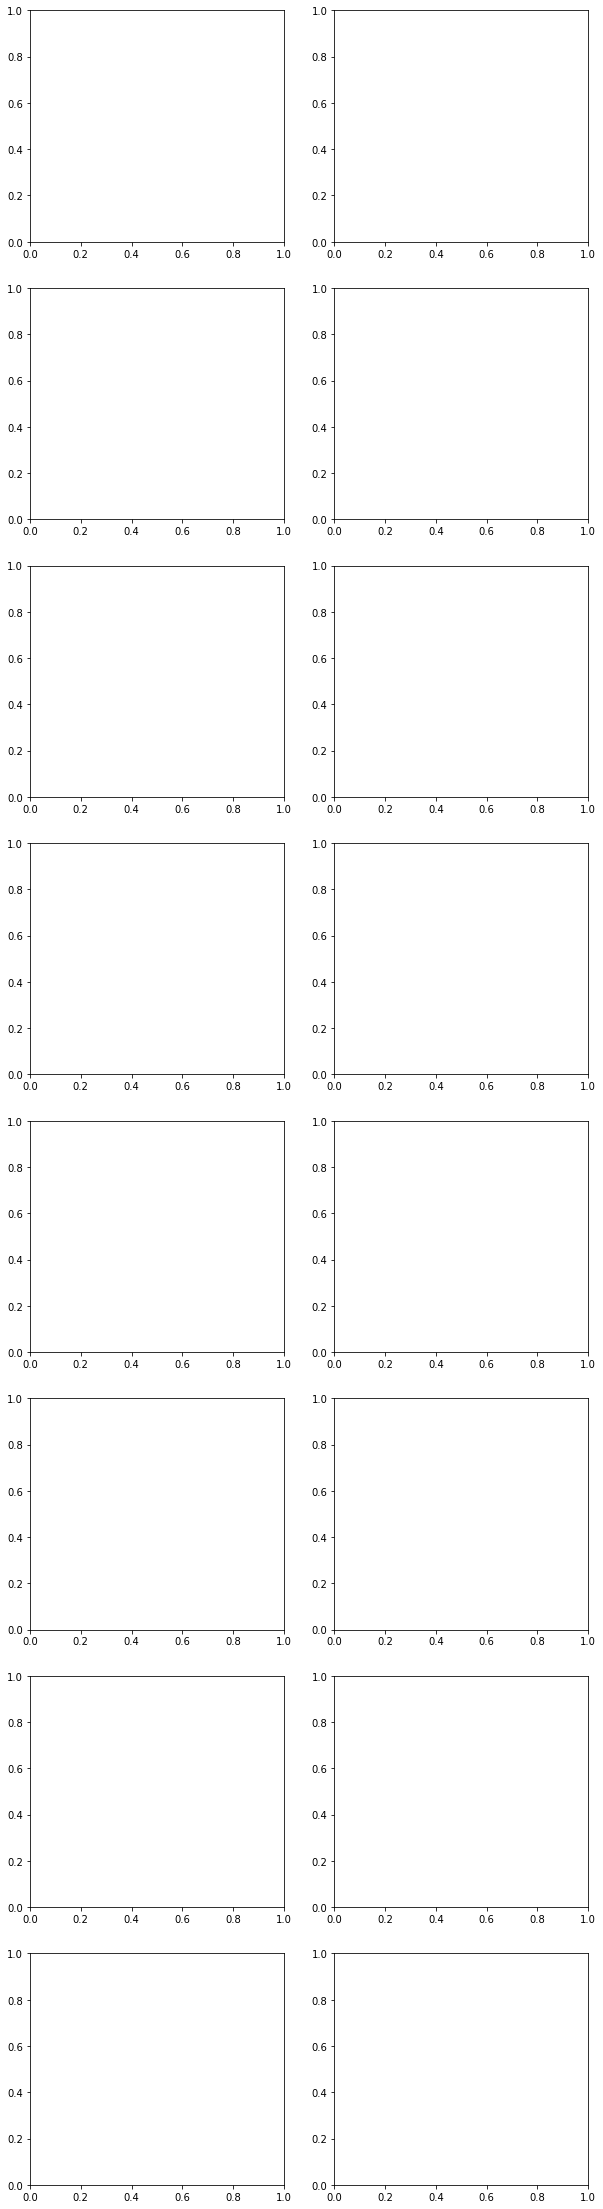

In [27]:
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(height, width).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

In [19]:
training_zip = 'train.zip'
x_tot,x2_tot = [],[]

with zipfile.ZipFile(training_zip, mode='w') as img_out:
    for file in train_parquet:
        df = pd.read_parquet(file)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, height, width).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)
        
            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)

100%|███████████████████████████████████████████████████████████████████████████| 50210/50210 [01:52<00:00, 447.77it/s]
